<a href="https://colab.research.google.com/github/johnryantaylor/QCES/blob/main/Project1_numerical_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 1: Diffusion equation

## 1. Background + Examples

In this project we will use several methods to solve the diffusion equation:

$$ \partial_t c = \kappa \partial_x^2 c $$

This project consists of two notebooks. First, in this notebook, we will solve this equation using second order finite differences to approximate the $x$-derivatives, and we will use both the explict Euler and Crank-Nicolson timestepping methods.

In the second notebook for this project, we will learn how to use Dedalus to solve the same problem using spectral methods.

The objective for this notebook is learn about spatial discretization and to compare the stability, accuracy, and speed of the Explicit euler and Crank-Nicolson methods when applied to the diffusion equation.

Student tasks are in [Section 2.1](#section2pt1) and [Section 2.2](#section2pt2).

Before we start, load in the required libraries

In [85]:
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import time


Now, define two functions to timestep the diffusion equation. The code below timesteps the diffusion equation using the expicit Euler method. The function takes in a vector of discrete positions, `x`, discrete times, `t`, and the diffusivity, `kappa`. The vectors `x` and `t` dictate the discretization of the problem in space and time, and the grid spacing must be constant in space and time. The boundary conditions are $\partial_x c=0$ at the starting and ending points in `x`.

In [86]:
def EE(x, t, kappa):
# This function timesteps the diffusion equation with homogeneous Neumann boundary conditions
# using the explicit Euler and second order finite difference methods

    start_time = time.time()  # Start a timer

    # Infer the uniform grid spacing:
    dx = (x[-1] - x[0]) / (len(x) - 1); dt = (t[-1] - t[0]) / (len(t) - 1)

    # Set the number of gridpoints in x and t
    Nx = len(x); Nt = len(t)

    # Builds a coefficient matrix, such that M*c is the discrete version of d/dx(c)
    M = (np.diag(np.ones(Nx-1), -1) - 2*np.diag(np.ones(Nx), 0) + np.diag(np.ones(Nx-1), 1)) / dx**2

    # Turn M into a sparse matrix to save memory and improve speed
    M = sp.csr_matrix(M)

    # Create an empty sparse array to store the solution
    c = np.zeros((Nx, Nt))

    c[:, 0] = set_ics(x, kappa, 10)  # Set the initial condition

    for k in range(1, Nt):  # loop over the number of timesteps
      c[:,k] = c[:,k-1] + dt * kappa * M @ c[:,k-1]
      # Enforce the boundary conditions (no flux)
      c[0, k] = c[1, k]
      c[-1, k] = c[-2, k]

    end_time = time.time()  # Print the elapsed time

    print(f"Explicit Euler method took {end_time - start_time:.2f} seconds")

    return c

Similarly, the function below timesteps the diffusion equation with the Crank-Nicolson method

In [87]:
def CN(x, t, kappa):
# This function timesteps the diffusion equation with homogeneous Neumann boundary conditions
# using the explicit Euler and second order finite difference methods
    start_time = time.time()  # Start a timer

    # Infer the uniform grid spacing:
    dx = (x[-1] - x[0]) / (len(x) - 1); dt = (t[-1] - t[0]) / (len(t) - 1)

    # Set the number of gridpoints in x and t
    Nx = len(x); Nt = len(t)

    # build a coefficient matrix, such that M*c is the discrete version of d/dx(c)
    M = (np.diag(np.ones(Nx-1), -1) - 2*np.diag(np.ones(Nx), 0) + np.diag(np.ones(Nx-1), 1)) / dx**2

    # Turn M into a sparse matrix to save memory and improve speed:
    M = sp.csr_matrix(M)

    A = sp.eye(Nx) - 0.5 * dt * kappa * M  # This matrix appears on the LHS in the C-N scheme
    A_inv = spla.inv(A) # Calculate the inverse of A (this only needs to be done once)

    # Create an empty sparse array to store the solution
    c = np.zeros((Nx, Nt))

    c[:, 0] = set_ics(x, kappa, 10)  # Set the initial condition

    for k in range(1, Nt): # loop over the number of timesteps
        c[:, k] = A_inv @ (c[:, k-1] + 0.5 * dt * kappa * (M @ c[:, k-1]))
        # Enforce the boundary conditions
        c[0, k] = c[1, k]
        c[-1, k] = c[-2, k]

    end_time = time.time()  # Print the elapsed time

    print(f"Crank-Nicolson method took {end_time - start_time:.2f} seconds")

    return c

Next, create a function to set the initial conditions. The exact solution to the unbounded diffusion equation with a delta function initial condition is:

$$\left(\frac{1}{4\pi\kappa t}\right)^{1/2}e^{-x^2/(4\kappa t)}$$

The function below sets the initial condition by evaluating the exact solution at a given time. Note that it is important that we don't evaluate the exact solution at `t_ic=0` since this will return a delta function which will be undefined on our finite grid. The value of `t_ic` is set within the `EE` and `CN` functions.

In [88]:
# Function to set the initial condition from the exact solution at time t_start
def set_ics(x, kappa, t_ic):
    c_ic = (4*np.pi*kappa*t_ic)**(-0.5)*np.exp(-x**2 / (4*kappa*t_ic))
    # Enforce the boundary conditions
    c_ic[0] = c_ic[1]
    c_ic[-1] = c_ic[-2]
    return c_ic


Finally, define some parameters and the x and t vectors:

In [89]:
# Defining parameters
kappa = 0.001  # diffusivity

# Timestepping parameters
t_start = 0  # start time (note that this is not the same time used to evaluate the exact solution to set the ICs)
t_end = 10  # end time
Nt = 1000  # number of timesteps

# Size of the physical domain
x_start = -1
x_end = 1
Nx = 100

t = np.linspace(t_start, t_end, Nt)  # Create a vector of times
x = np.linspace(x_start, x_end, Nx)  # Create a vector for x

Run each method once:

In [90]:
# Run the simulations
c_EE = EE(x, t, kappa) # explicit Euler
c_CN = CN(x, t, kappa) # Crank-Nicolson

Explicit Euler method took 0.25 seconds
Crank-Nicolson method took 0.10 seconds


and finally, plot the results side-by-side

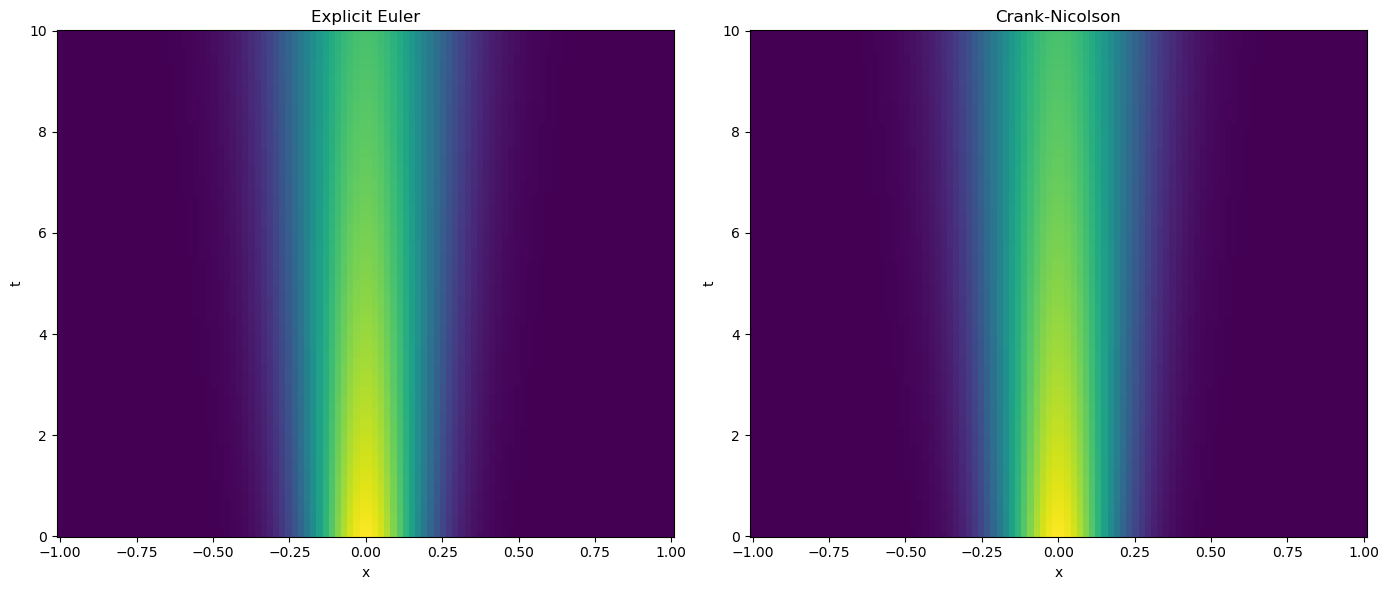

In [91]:
# Plot the results
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.pcolormesh(x, t, c_EE.T, shading='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Explicit Euler')

plt.subplot(1, 2, 2)
plt.pcolormesh(x, t, c_CN.T, shading='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Crank-Nicolson')

plt.tight_layout()
plt.show()

## 2. Student investigation

### 2.1 Stability


<a id='section2pt1'></a>
The explicit Euler and Crank-Nicolson methods have very different stability properties. To explore this, try increasing Nx (decreasing the grid spacing, $\Delta x$) and/or increase the diffusivity, $\kappa$, and see how each method responds. How does the stability depend on `Nx`? Discuss your findings below (~1 paragraph)

<font color='darkorange'> For the Explicit Euler method, the system is stable when $$\kappa \frac{\Delta t}{(\Delta x)^2}<\frac{1}{2}$$ </font>



<>:34: SyntaxWarning: invalid escape sequence '\k'
<>:37: SyntaxWarning: invalid escape sequence '\k'
<>:38: SyntaxWarning: invalid escape sequence '\D'
<>:39: SyntaxWarning: invalid escape sequence '\D'
<>:34: SyntaxWarning: invalid escape sequence '\k'
<>:37: SyntaxWarning: invalid escape sequence '\k'
<>:38: SyntaxWarning: invalid escape sequence '\D'
<>:39: SyntaxWarning: invalid escape sequence '\D'
/var/folders/d0/r13mw5g137n8_l0hws_ds7bm0000gn/T/ipykernel_14251/4201812863.py:34: SyntaxWarning: invalid escape sequence '\k'
  plt.plot([], [], color=colors[i], label=f'$\kappa$ = {kappa}')
/var/folders/d0/r13mw5g137n8_l0hws_ds7bm0000gn/T/ipykernel_14251/4201812863.py:37: SyntaxWarning: invalid escape sequence '\k'
  plt.title('Stability Boundaries for EE method with varying $\kappa$')
/var/folders/d0/r13mw5g137n8_l0hws_ds7bm0000gn/T/ipykernel_14251/4201812863.py:38: SyntaxWarning: invalid escape sequence '\D'
  plt.xlabel('$\Delta x$')
/var/folders/d0/r13mw5g137n8_l0hws_ds7bm0000gn/

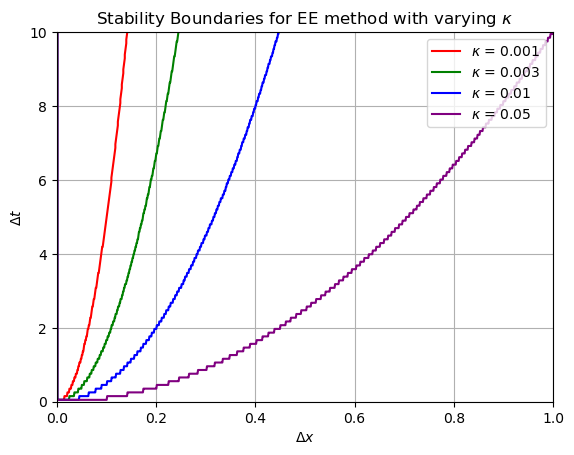

In [92]:
# Going to define some meshgrid of t and x values and then for different values of kappa we can plot different lines of stability


import numpy as np
import matplotlib.pyplot as plt

# Define the ranges
delta_x_values = np.linspace(0, 1, 1000)
delta_t_values = np.linspace(0, 10, 100)
kappa_values = [0.001, 0.003, 0.01, 0.05]

plt.figure()

# Define a list of colors (one for each kappa)
colors = ['r', 'g', 'b', 'purple']  # Specify colors for each kappa

# Loop over each kappa value
for i, kappa in enumerate(kappa_values):
    stability_matrix = np.zeros((len(delta_x_values), len(delta_t_values)))

    # Fill the stability matrix
    for j, delta_x in enumerate(delta_x_values):
        for k, delta_t in enumerate(delta_t_values):
            if delta_x != 0:  # Avoid division by zero for delta_x = 0
                stability_matrix[j, k] = kappa * delta_t / (delta_x)**2

    # Identify values below 0.5
    below_threshold = stability_matrix < 0.5

    # Plot the boundary using `plt.contour` with specified color
    contour = plt.contour(delta_x_values, delta_t_values, below_threshold.T, levels=[0.5], colors=colors[i])

    # Add a label for the line in the legend
    plt.plot([], [], color=colors[i], label=f'$\kappa$ = {kappa}')

# Add title and labels
plt.title('Stability Boundaries for EE method with varying $\kappa$')
plt.xlabel('$\Delta x$')
plt.ylabel('$\Delta t$')
plt.grid(True)

# Add a legend
plt.legend()

# Show the plot
plt.show()









<font color='darkorange'> 

The graph above analyses the stability of the Explicity Euler method:

Region of acceptance is below the  lines of the graph for each of the respective 4 values of kappa tested. 

1. Physical enterpretation: 
    * Small spatial steps ($\Delta x$) resolve finder details, so stability requires small time steps ($\Delta t$) to prevent numerical divergence 
    * large spatial steps ($\Delta x$) are more forgiving alowing for larger time steps ($\Delta t$)
2. Observed Stability region:
    * The stable region lies below the boundary because this is where the stability condition is met 
    * As expected, the stability region decreases in size for largers values of the diffusivity $\kappa$ as this corresponds to a higher rate of diffusion that is more liekly to cause numerical divergence in the numberal method. 

For the Crank-Nicolson Method:

* The method is implicit with unconditional stability for diffusion problems. 
* The model may become less accurate for coarse enough ($\Delta t$) but does is broadly unaffected by changes to $\Delta x$ and also remains stable even for large diffusivities

</font>

### 2.2 Accuracy



<a id='section2pt2'></a>
Next, we will examine the accuracy of the numerical methods used above. In order to do this, it is useful to compare our numerical solutions with the exact solution to the diffusion equation. Below, write code to plot the exact solution and the numerical solution using explicit Euler and Crank-Nicolson at the final time ($t=10$). Note that you can use the exact solution to the diffusion equation in an unbounded domain in $x$ and keep in mind that the exact solution and numerical solutions will differ for later times when boundary effects are felt.


The exact solution to the diffusion equation is given by:


$$\left(\frac{1}{4\pi\kappa t}\right)^{1/2}e^{-x^2/(4\kappa t)}$$




#### Investigation 1 - Errors due to boundary conditions



<font color='darkorange'> 

The first investigation is to make an assessment of the error between the two numerical methods and the exact solution to the diffusion equation. We investigate the errors at $t=10$:

</font>

Explicit Euler method took 0.06 seconds
Crank-Nicolson method took 0.11 seconds


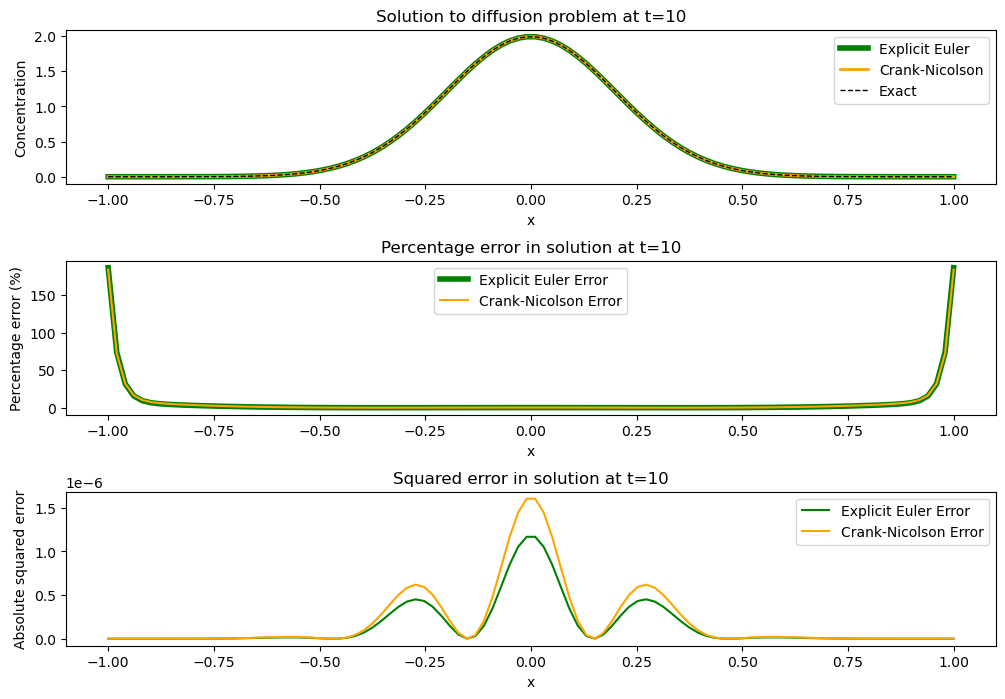

In [93]:
# This is an investigation of the width over which each numerical method accurately represents the exact solution to the diffusion equation


kappa = 0.001  # diffusivity

# Timestepping parameters
t_start = 0  # start time (note that this is not the same time used to evaluate the exact solution to set the ICs)
t_end = 10  # end time
Nt = 1000  # number of timesteps

# Size of the physical domain
x_start = -1
x_end = 1
Nx = 100

t = np.linspace(t_start, t_end, Nt)  # Create a vector of times
x = np.linspace(x_start, x_end, Nx)  # Create a vector for x


c_EE = EE(x, t, kappa) # explicit Euler
c_CN = CN(x, t, kappa) # Crank-Nicolson
c_exact = (1/(4*np.pi*kappa*(t_end+10)))**0.5*np.exp(-x**2/(4*kappa*(t_end+10)))


fig, ax1 = plt.subplots(figsize=(12,8), nrows=3)
fig.subplots_adjust(hspace=0.5)
ax1=ax1.flatten()


ax1[0].plot(x, c_EE[:,-1], c='green', label='Explicit Euler', lw=4)
ax1[0].plot(x, c_CN[:,-1], c='orange', label='Crank-Nicolson', lw=2)
ax1[0].plot(x, c_exact, 'k--', label='Exact', lw=1)
ax1[0].legend()

ax1[0].set_xlabel('x')
ax1[0].set_ylabel('Concentration')

ax1[1].plot(x, (c_EE[:,-1]-c_exact)/c_exact *100, c='green', label='Explicit Euler Error', lw=4)
ax1[1].plot(x, (c_CN[:,-1]-c_exact)/c_exact *100, c='orange', label='Crank-Nicolson Error')
ax1[1].legend()

ax1[1].set_xlabel('x')
ax1[1].set_ylabel('Percentage error (%)')

ax1[2].plot(x, (c_EE[:,-1]-c_exact)**2, c='green', label='Explicit Euler Error')
ax1[2].plot(x, (c_CN[:,-1]-c_exact)**2, c='orange', label='Crank-Nicolson Error')
ax1[2].set_xlabel('x')
ax1[2].set_ylabel('Absolute squared error')
ax1[2].legend()

ax1[0].set_title('Solution to diffusion problem at t=10')
ax1[1].set_title('Percentage error in solution at t=10')
ax1[2].set_title('Squared error in solution at t=10')

plt.show()

<font color='darkorange'> **Investigation 1 discussion**

From the plots above it can be seen that around the centre of the diffusion, both the Explicit Euler and Crank-Nicolson numerical models give good approximations to the exact diffusion equation with a low percentage error. At greater distances from the diffusion, the percentage error in the numberical model increases. There is a large error between the exact solution and the numberical models for distances close to the boundary. 

As the diffusion equation that produces the exact solution is beting modelled as an unbounded 1-D diffusion equation but the numerical solutions impose bondary conditions in the x dimension this large deviation close to the boundary of the numberical models is to be expected. It should be noted however that the absolute error of the numerical models in this region is small compared to the values present in the central region of the graph, and also that the model capture the diffusion profile well at the endtime being investigated.

</font>

#### Investigation 2 - Errors due to grid spacing and timestep


Now, define a measure of the error of each numerical method compared to the exact solution (there is no single correct way to do this). Plot the error of both methods as a function of the grid spacing $\Delta x$. Then, similarly plot the error as a function of the timestep, $\Delta t$.

<font color='darkorange'> I am choosing to define the 'error' and the squared difference between the true value and the modeled value by the numerical method. </font>

In [94]:
kappa = 0.001  # diffusivity

# Timestepping parameters
t_start = 0  # start time (note that this is not the same time used to evaluate the exact solution to set the ICs)
t_end = 10  # end time

# Size of the physical domain
x_start = -1
x_end = 1


In [95]:
# This makes an array of values for both Nt and Nx based upon a log scale
Nt_num = 15
Nx_num = 15

#Nt_values = np.logspace(3, 4, Nt_num, base=10)
#Nx_values = np.logspace(2, 3, Nx_num, base=10)

Nt_values = np.linspace(200, 1500, Nt_num).astype(int)
Nx_values = np.linspace(50, 200, Nx_num).astype(int)


# This makes a mesh of the
Nt_mesh, Nx_mesh = np.meshgrid(Nt_values, Nx_values)

# The exact run for the



# Create an empty 2D array for the EE and CN runs

EE_2d = np.zeros((len(Nt_values), len(Nx_values)))
CN_2d = np.zeros((len(Nt_values), len(Nx_values)))


# This iterates through each value of
for i in range(len(Nx_values)):
    for j in range(len(Nt_values)):
      Nt = Nt_mesh[i,j].astype(int)
      Nx = Nx_mesh[i,j].astype(int)

      t = np.linspace(t_start, t_end, Nt)  # Create a vector of times
      x = np.linspace(x_start, x_end, Nx)

      c_exact = (1/(4*np.pi*kappa*(t_end+10)))**0.5*np.exp(-x**2/(4*kappa*(t_end+10)))
      c_EE = EE(x, t, kappa) # explicit Euler
      c_CN = CN(x, t, kappa) # Crank-Nicolson

      EE_2d[i,j] = np.sum((c_EE[:, -1]-c_exact)**2)
      CN_2d[i,j] = np.sum((c_CN[:, -1]-c_exact)**2)






Explicit Euler method took 0.01 seconds
Crank-Nicolson method took 0.02 seconds
Explicit Euler method took 0.02 seconds
Crank-Nicolson method took 0.02 seconds
Explicit Euler method took 0.12 seconds
Crank-Nicolson method took 0.03 seconds
Explicit Euler method took 0.02 seconds
Crank-Nicolson method took 0.02 seconds
Explicit Euler method took 0.02 seconds
Crank-Nicolson method took 0.02 seconds
Explicit Euler method took 0.03 seconds
Crank-Nicolson method took 0.02 seconds
Explicit Euler method took 0.03 seconds
Crank-Nicolson method took 0.02 seconds
Explicit Euler method took 0.04 seconds
Crank-Nicolson method took 0.02 seconds
Explicit Euler method took 0.04 seconds
Crank-Nicolson method took 0.03 seconds
Explicit Euler method took 0.04 seconds
Crank-Nicolson method took 0.03 seconds
Explicit Euler method took 0.04 seconds
Crank-Nicolson method took 0.03 seconds
Explicit Euler method took 0.05 seconds
Crank-Nicolson method took 0.03 seconds
Explicit Euler method took 0.05 seconds


<>:9: SyntaxWarning: invalid escape sequence '\D'
<>:10: SyntaxWarning: invalid escape sequence '\D'
<>:18: SyntaxWarning: invalid escape sequence '\D'
<>:19: SyntaxWarning: invalid escape sequence '\D'
<>:9: SyntaxWarning: invalid escape sequence '\D'
<>:10: SyntaxWarning: invalid escape sequence '\D'
<>:18: SyntaxWarning: invalid escape sequence '\D'
<>:19: SyntaxWarning: invalid escape sequence '\D'
/var/folders/d0/r13mw5g137n8_l0hws_ds7bm0000gn/T/ipykernel_14251/461747955.py:9: SyntaxWarning: invalid escape sequence '\D'
  plt.xlabel('$\Delta t$')
/var/folders/d0/r13mw5g137n8_l0hws_ds7bm0000gn/T/ipykernel_14251/461747955.py:10: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel('$\Delta x$')
/var/folders/d0/r13mw5g137n8_l0hws_ds7bm0000gn/T/ipykernel_14251/461747955.py:18: SyntaxWarning: invalid escape sequence '\D'
  plt.xlabel('$\Delta t$')
/var/folders/d0/r13mw5g137n8_l0hws_ds7bm0000gn/T/ipykernel_14251/461747955.py:19: SyntaxWarning: invalid escape sequence '\D'
  plt.ylab

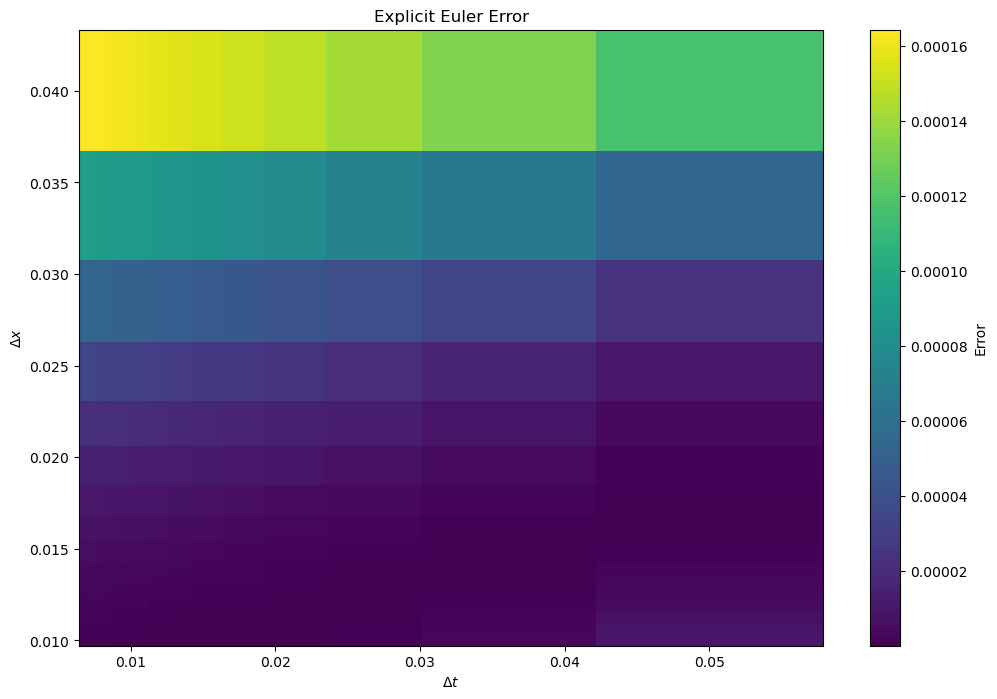

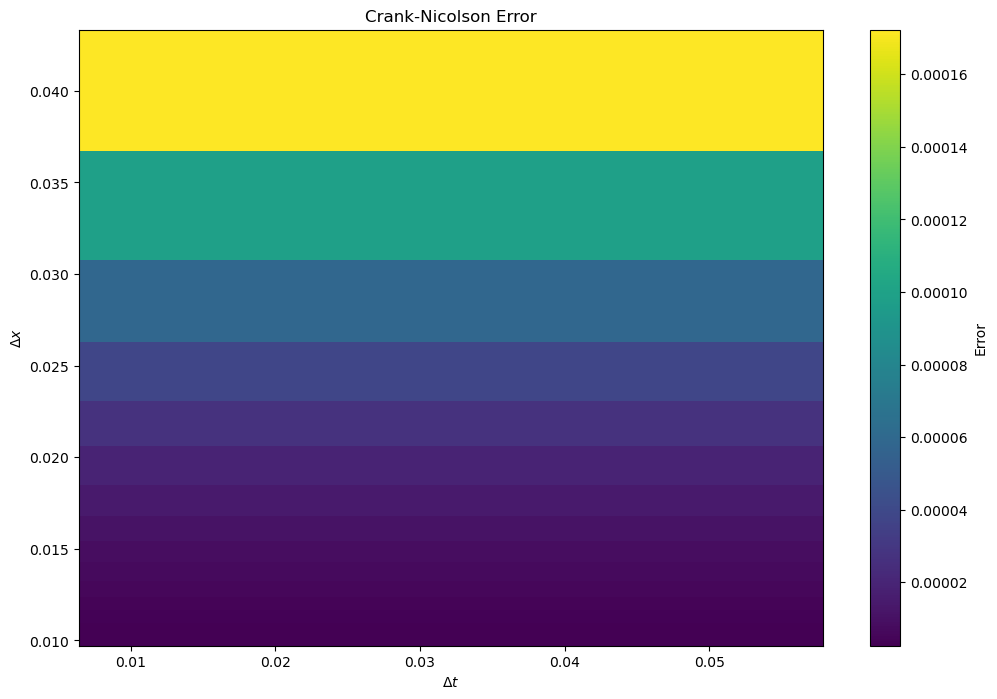

In [102]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import pandas as pd


plt.figure(figsize=(12, 8))
plt.pcolor(10/Nt_mesh, 2/Nx_mesh, EE_2d, cmap='viridis', shading='auto')
plt.colorbar(label='Error')
plt.xlabel('$\Delta t$')
plt.ylabel('$\Delta x$')
plt.title('Explicit Euler Error')
plt.show()

# Crank-Nicolson Error Surface as 2D
plt.figure(figsize=(12, 8))
plt.pcolor(10/Nt_mesh, 2/Nx_mesh, CN_2d, cmap='viridis', shading='auto')
plt.colorbar(label='Error')
plt.xlabel('$\Delta t$')
plt.ylabel('$\Delta x$')
plt.title('Crank-Nicolson Error')
plt.show()


<>:26: SyntaxWarning: invalid escape sequence '\D'
<>:29: SyntaxWarning: invalid escape sequence '\D'
<>:26: SyntaxWarning: invalid escape sequence '\D'
<>:29: SyntaxWarning: invalid escape sequence '\D'
/var/folders/d0/r13mw5g137n8_l0hws_ds7bm0000gn/T/ipykernel_14251/2206869351.py:26: SyntaxWarning: invalid escape sequence '\D'
  ax.set_xlabel('$\Delta x$')
/var/folders/d0/r13mw5g137n8_l0hws_ds7bm0000gn/T/ipykernel_14251/2206869351.py:29: SyntaxWarning: invalid escape sequence '\D'
  ax.set_title('Error as a function of $\Delta x$')
/Users/maxharvey/miniforge3/envs/dedalus3/lib/python3.13/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/Users/maxharvey/miniforge3/envs/dedalus3/lib/python3.13/site-packages/scipy/sparse/linalg/_matfuncs.py:76: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  Ainv = spsolve(A, I)


Explicit Euler method took 0.24 seconds
Crank-Nicolson method took 0.03 seconds
Explicit Euler method took 0.06 seconds
Crank-Nicolson method took 0.03 seconds
Explicit Euler method took 0.06 seconds
Crank-Nicolson method took 0.03 seconds
Explicit Euler method took 0.07 seconds
Crank-Nicolson method took 0.03 seconds
Explicit Euler method took 0.06 seconds
Crank-Nicolson method took 0.03 seconds
Explicit Euler method took 0.06 seconds
Crank-Nicolson method took 0.03 seconds
Explicit Euler method took 0.07 seconds
Crank-Nicolson method took 0.03 seconds
Explicit Euler method took 0.06 seconds
Crank-Nicolson method took 0.03 seconds
Explicit Euler method took 0.06 seconds
Crank-Nicolson method took 0.04 seconds
Explicit Euler method took 0.07 seconds
Crank-Nicolson method took 0.03 seconds
Explicit Euler method took 0.06 seconds
Crank-Nicolson method took 0.03 seconds
Explicit Euler method took 0.07 seconds
Crank-Nicolson method took 0.04 seconds
Explicit Euler method took 0.06 seconds


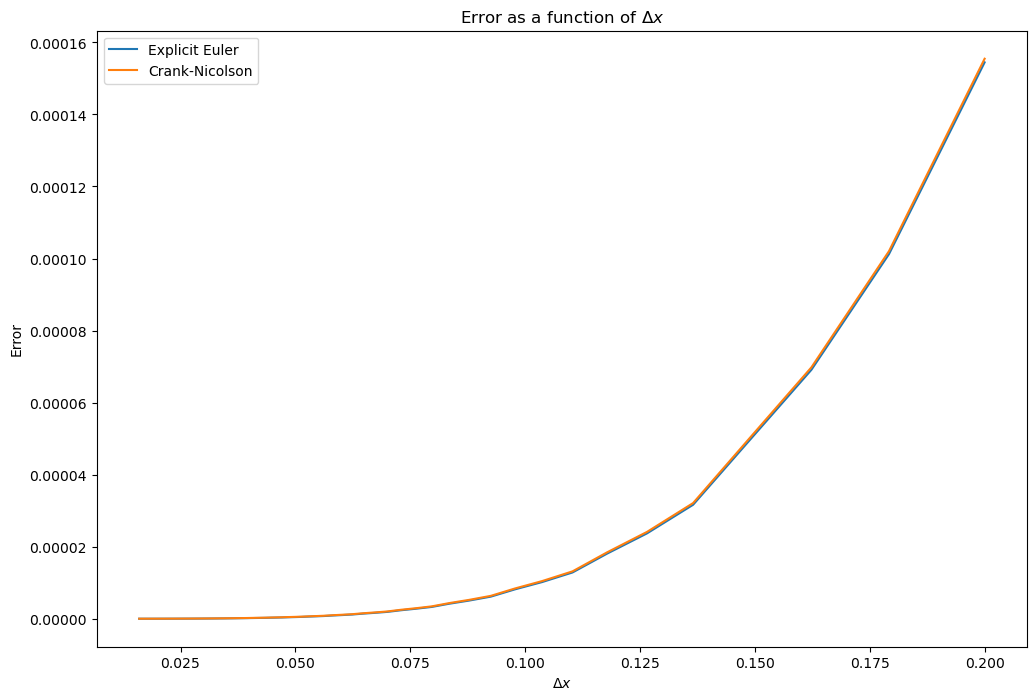

In [113]:
# Let's also just do either delta x or delta t at once as well but with newly just 1D arrays of delta x or delta t values:

def exact(x,t):
    return (1/(4*np.pi*kappa*(t+10)))**0.5*np.exp(-x**2/(4*kappa*(t+10)))

Nx_values = np.linspace(20, 250, 100)
EE_Nx_errors = np.empty_like(Nx_values)
CN_Nx_errors = np.empty_like(Nx_values)
Nt_const_value = 1000

Nt_values = np.linspace(200, 1500, 100)
EE_Nt_errors = np.zeros(len(Nt_values))
CN_Nt_errors = np.zeros(len(Nt_values))
Nx_const_value = 100

for i, Nx in enumerate(Nx_values):
    x_new = np.linspace(x_start, x_end, int(Nx))
    c_EE = EE(x_new, t, kappa)
    c_CN = CN(x_new, t, kappa)
    EE_Nx_errors[i] = np.sum(np.abs(c_EE[:, -1] - exact(x_new, 10))**2)
    CN_Nx_errors[i] = np.sum(np.abs(c_CN[:, -1] - exact(x_new, 10))**2)

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(4/Nx_values, EE_Nx_errors/Nx_values, label='Explicit Euler')
ax.plot(4/Nx_values, CN_Nx_errors/Nx_values, label='Crank-Nicolson')
ax.set_xlabel('$\Delta x$')
ax.set_ylabel('Error')
ax.legend()
ax.set_title('Error as a function of $\Delta x$')
plt.show()



<>:19: SyntaxWarning: invalid escape sequence '\D'
<>:19: SyntaxWarning: invalid escape sequence '\D'
/var/folders/d0/r13mw5g137n8_l0hws_ds7bm0000gn/T/ipykernel_14251/729885128.py:19: SyntaxWarning: invalid escape sequence '\D'
  ax.set_title('Error vs $\Delta t$ for Explicit Euler and Crank-Nicolson')
/Users/maxharvey/miniforge3/envs/dedalus3/lib/python3.13/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/Users/maxharvey/miniforge3/envs/dedalus3/lib/python3.13/site-packages/scipy/sparse/linalg/_matfuncs.py:76: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  Ainv = spsolve(A, I)


Explicit Euler method took 0.02 seconds
Crank-Nicolson method took 0.15 seconds
Explicit Euler method took 0.01 seconds
Crank-Nicolson method took 0.03 seconds
Explicit Euler method took 0.02 seconds
Crank-Nicolson method took 0.08 seconds
Explicit Euler method took 0.01 seconds
Crank-Nicolson method took 0.02 seconds
Explicit Euler method took 0.01 seconds
Crank-Nicolson method took 0.03 seconds
Explicit Euler method took 0.01 seconds
Crank-Nicolson method took 0.03 seconds
Explicit Euler method took 0.01 seconds
Crank-Nicolson method took 0.03 seconds
Explicit Euler method took 0.01 seconds
Crank-Nicolson method took 0.03 seconds
Explicit Euler method took 0.01 seconds
Crank-Nicolson method took 0.03 seconds
Explicit Euler method took 0.01 seconds
Crank-Nicolson method took 0.03 seconds
Explicit Euler method took 0.02 seconds
Crank-Nicolson method took 0.03 seconds
Explicit Euler method took 0.02 seconds
Crank-Nicolson method took 0.03 seconds
Explicit Euler method took 0.01 seconds


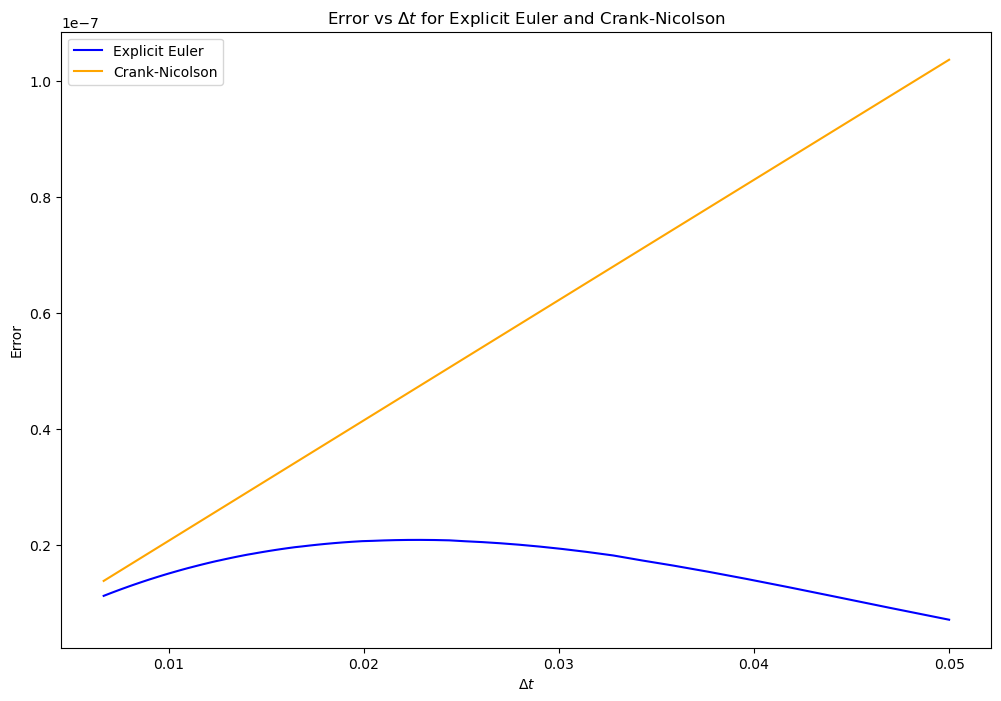

In [112]:
# Varying delta t (Nt_values) while keeping Nx constant
for i, Nt in enumerate(Nt_values):
    t_new = np.linspace(0, t_end, int(Nt))  # Time grid
    x_new = np.linspace(x_start, x_end, int(Nx_const_value))  # Spatial grid (constant Nx)
    
    c_EE = EE(x_new, t_new, kappa)  # Explicit Euler solution
    c_CN = CN(x_new, t_new, kappa)  # Crank-Nicolson solution
    
    # Compute the squared error at the final time step
    EE_Nt_errors[i] = np.sum(np.abs(c_EE[:, -1] - exact(x_new, t_end))**2)
    CN_Nt_errors[i] = np.sum(np.abs(c_CN[:, -1] - exact(x_new, t_end))**2)

# Plot the results
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(10 / Nt_values, EE_Nt_errors/Nt_values, label='Explicit Euler', color='blue')
ax.plot(10 / Nt_values, CN_Nt_errors/Nt_values, label='Crank-Nicolson', color='orange')
ax.set_xlabel(r'$\Delta t$')
ax.set_ylabel('Error')
ax.set_title('Error vs $\Delta t$ for Explicit Euler and Crank-Nicolson')
ax.legend()
plt.show()


<font color='darkorange'> 

2D plotting: 

* The first set of graphs - show 2d colormesh plots of the errors for a grid of $\Delta t$ and $\Delta x$ values. 
* We see that both methods seems to have the same error dependence upon changing $\Delta x$. 
* We see that the CN method seems unaffected by changes in $\Delta t$ over the region tested whereas the error in the EE method appear to have a linear dependence upon the variation in the $\Delta t$ values. 

Line graphs:

* The line graphs, confirm these observed relationships. 
* However, this has only been tested for 1 kappa value and not over a vast range of $\Delta t$ or $\Delta x$ values so further analysis could be perfomed.

Sanity:
* The error in the explicit euler method decreases with increasing $\Delta t$. This may at first seem counterintuitive. However, it could be that at larger values of $\Delta t$, the Explicit Euler method samples the solution less frequently in time. This can effectively "hide" or average out high-frequency oscillations or numerical instabilities that contribute to the error. This could essentially create a less accurate 'average' solution which happens to coincidentally reduce the error. 

Redefining how you 'measure' error: 
* The final line plots - calcualted residual square error by the number of timesteps of spatial steps to give an 'error per incremenent'. This produces differeing behaviours and could be used to reveal other properties of the models. It also shows the large impact of how you choose to measure 'error' in your model.
</font>

#### Investigation 3 - Computational Speed

Finally, select a given error tolerance and explore whether explicit Euler or Crank-Nicoslon is more efficient (faster) at generating solutions with error less than your error tolerance. Discuss your conclusion and add supporting figures if necessary.

Explicit Euler method took 0.21 seconds
Crank-Nicolson method took 0.05 seconds
Explicit Euler method took 0.07 seconds
Crank-Nicolson method took 0.03 seconds


/Users/maxharvey/miniforge3/envs/dedalus3/lib/python3.13/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/Users/maxharvey/miniforge3/envs/dedalus3/lib/python3.13/site-packages/scipy/sparse/linalg/_matfuncs.py:76: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  Ainv = spsolve(A, I)


Explicit Euler method took 0.07 seconds
Crank-Nicolson method took 0.06 seconds
Explicit Euler method took 0.07 seconds
Crank-Nicolson method took 0.03 seconds
Explicit Euler method took 0.07 seconds
Crank-Nicolson method took 0.04 seconds
Explicit Euler method took 0.17 seconds
Crank-Nicolson method took 0.05 seconds
Explicit Euler method took 0.10 seconds
Crank-Nicolson method took 0.03 seconds
Explicit Euler method took 0.08 seconds
Crank-Nicolson method took 0.04 seconds
Explicit Euler method took 0.08 seconds
Crank-Nicolson method took 0.04 seconds
Explicit Euler method took 0.08 seconds
Crank-Nicolson method took 0.05 seconds
Explicit Euler method took 0.08 seconds
Crank-Nicolson method took 0.04 seconds
Explicit Euler method took 0.08 seconds
Crank-Nicolson method took 0.04 seconds
Explicit Euler method took 0.08 seconds
Crank-Nicolson method took 0.05 seconds
Explicit Euler method took 0.11 seconds
Crank-Nicolson method took 0.05 seconds
Explicit Euler method took 0.07 seconds


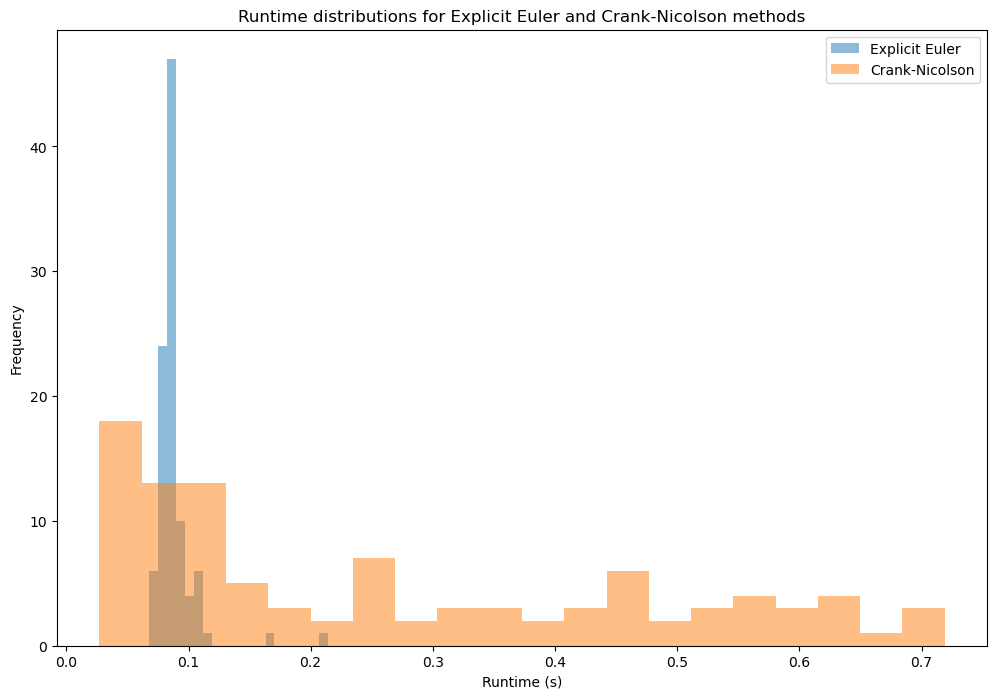

In [119]:
import numpy as np
import time  # To measure runtime

# Define arrays to store the runtimes
explicit_euler_runtimes = []
crank_nicolson_runtimes = []

# Assuming you have the other necessary parts of the code like Nx_values, t_start, t_end, etc.

# Loop over Nx values
for i, nx in enumerate(Nx_values):
    x_new = np.linspace(x_start, x_end, int(nx))  # Vary spatial resolution

    # Measure runtime for Explicit Euler method
    start_time = time.time()
    c_EE = EE(x_new, t_new, kappa)
    end_time = time.time()
    ee_runtime = end_time - start_time
    explicit_euler_runtimes.append(ee_runtime)  # Store runtime

    # Measure runtime for Crank-Nicolson method
    start_time = time.time()
    c_CN = CN(x_new, t_new, kappa)
    end_time = time.time()
    cn_runtime = end_time - start_time
    crank_nicolson_runtimes.append(cn_runtime)  # Store runtime

# And let's plot histograms of the runtimes for each method
fig, ax = plt.subplots(figsize=(12, 8))
ax.hist(explicit_euler_runtimes, bins=20, alpha=0.5, label='Explicit Euler')
ax.hist(crank_nicolson_runtimes, bins=20, alpha=0.5, label='Crank-Nicolson')
ax.set_xlabel('Runtime (s)')
ax.set_ylabel('Frequency')
ax.set_title('Runtime distributions for Explicit Euler and Crank-Nicolson methods')
ax.legend()
plt.show()




Now, move to Project1_dedalus.ipynb which will introduce Dedalus and spectral methods.

<font color='darkorange'> 
As can be seen in experiment 2, the explicit euler method provides lower error for all spatial and temporal resolutions that were investigated. 

This histrogram shows that the EE method is also on average much faster to compute than the CN method.

However, as discussed in experiment 1 and 2, the CN method offers much greater stabiltiy across a wider range of temporal and spatial resolutions. 

Therefore, if the region over which calcualtion is required lies within a region know to be well covered by the EE method, then this method should be selected as it offers greater computational speed. 

However, if a wide range of temporal or spatial resolutions needs to be tested, or the behaviour of the EE method is not well documented in the region needing to be tested, it is better to opt for the less computationally efficient CN method as the stability is much greater. 
</font>

## 3. Optional further investigations



The application of the boundary conditions for the Crank-Nicolson method isn't quite right in the script above (but the boundary conditions aren't very important in this example). Account for the boundary conditions by modifying the coefficient matrix. This ensures that the boundary conditions are applied to the implicit and explicit terms involved in the Crank-Nicolson update. How would you handle fixed value (Dirichlet) and fixed gradient (Neumann) boundary conditions?